In [15]:
"""
updated 2019-08-09 
written by Minhae Kwon
Multinomial logistic regression for "Decoding" process
ref: https://chrisalbon.com/machine_learning/naive_bayes/multinomial_logistic_regression/


ver 3.0: try use Kernel Ridge Regression

ver 2.0: try use Radial Basis Function for nonlinear transform (manually)


"""
from pandas import DataFrame, read_csv
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
#from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import matplotlib.pyplot as plt

TEST_SIZE = 0.2  # ratio of test data set 
N_SPLITS = 2 # "K" in K-fold cross validation 

#if you use neural data
bb_df = read_csv('./data/bb_df.csv') #behavior belief =[belief for box1, beleif for box2]
bb_df_prev = read_csv('./data/recoding_bb_prev_df.csv') #behavior belief =[belief for box1, beleif for box2]
bb_df_now = read_csv('./data/recoding_bb_now_df.csv') #behavior belief =[belief for box1, beleif for box2]


### if you use pomdp data

In [16]:
data = read_csv('./data/pomdp_data.csv')

In [17]:
nb_df_raw = data[['box1 belief', 'box2 belief','location']].to_numpy()#[:10000]
a_df = data['action'].to_numpy()#[:10000]

X = nb_df_raw
y = a_df

# rescale beleif in order to make a same distance to location
X[:,:2] = X[:,:2]*10  

### there are 3 types of data: test data, train data, validation data

In [18]:
# separate test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state = 1)

In [19]:
#regr = LinearRegression() # linear regression is used for encoding process
regr = KernelRidge(alpha=0.01, gamma=0.1, kernel='rbf') # linear regression(small gamma) with RBF kernel


In [20]:
# now we use only train data 
# why use StratifiedKFold?: The folds are made by preserving the percentage of samples for each class.
k_fold = StratifiedKFold(n_splits=N_SPLITS) # seperate train data and validation data

In [21]:
# why argmax(1)? split cannot simply handle multidimension y. 
# ref: https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
for train_index, val_index in k_fold.split(X_train, y_train):
    #print("TRAIN:", train_index, "TEST:", val_index)
    x_train_kf, x_val_kf = X[train_index], X[val_index]
    y_train_kf, y_val_kf = y[train_index], y[val_index]
    #print(x_train_kf)
    #print(y_train_kf)
    regr.fit(x_train_kf, y_train_kf) # fit the model
    pred = regr.predict(x_val_kf) # predict based on current model -> use validation data for evaluation
    #print(pred)
    #print(y_val_kf)
    print('score', r2_score(y_val_kf, pred, multioutput='raw_values')) # get r2 score

score [0.52297072]
score [0.51208144]


In [22]:
regr.dual_coef_


array([-95.60645037, -61.88976416, 154.43280049, ..., -92.67558149,
        36.84789613, 238.11023584])

### evaluate model with test data

In [23]:
predic_X_test = regr.predict(X_test)


decoding_accuracy = sum(y_test - predic_X_test)/y_test.shape[0] 
# true == estimate
print('decoding_accuracy[%]:', decoding_accuracy*100)
print('score', r2_score(y_test, predic_X_test, multioutput='raw_values'))




#recoding_error = (y_test - predic_X_test)**2 # true - estimate
#print('Mean squared error: \n', np.mean(recoding_error, axis=0))
#print('squared error std:\n', np.std(recoding_error, axis=0))
#print('score', r2_score(y_test, predic_X_test, multioutput='raw_values'))

decoding_accuracy[%]: -0.2663954082171727
score [0.5251156]


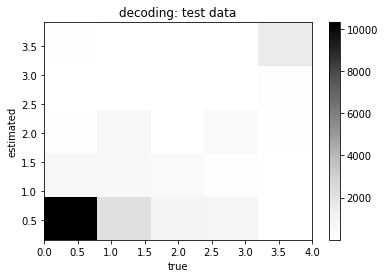

In [24]:
# plot: compare raw data vs prediction
#plt.scatter(a_df_test, a_dec_test, s=0.005, c='blue', marker='o')
plt.hist2d(y_test[:], predic_X_test[:], bins=(5,5), cmap=plt.cm.Greys)
plt.colorbar()
plt.xlabel('true')
plt.ylabel('estimated')
plt.title('decoding: test data')
plt.show()

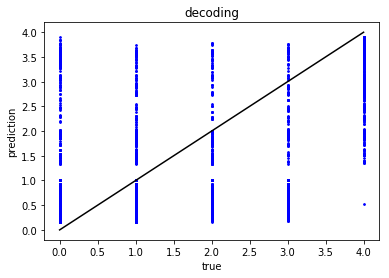

In [25]:
line_x = np.linspace(0,4,num=11)
line_y = np.linspace(0,4,num=11)


# plot: compare raw data vs prediction
plt.scatter(y_test[:], predic_X_test[:], s=3, c='blue', marker='o')
plt.plot(line_x, line_y,c='k')
plt.xlabel('true')
plt.ylabel('prediction')
plt.title('decoding')
plt.show()



In [26]:
xedges = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
yedges = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
H, xedges, yedges = np.histogram2d(y_test, predic_X_test, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.
print(H)
print(np.sum(H,axis=0))

[[6250. 1330.  416.  211.    0.]
 [4656. 1164.  832.  878.   11.]
 [ 169.  874.  346.  501.  156.]
 [  75.   58.   41.   43.  581.]
 [ 106.   25.   21.   25. 1231.]]
[11256.  3451.  1656.  1658.  1979.]


Text(0.5, 1.0, 'Decoding: unormalzied heatmap')

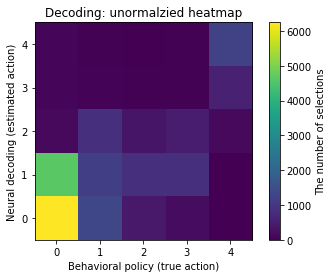

In [27]:
# this is the same plot with the above black and white figure
plt.imshow(H, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
cbar = plt.colorbar()
cbar.set_label('The number of selections')
plt.xlabel('Behavioral policy (true action)') 
plt.ylabel('Neural decoding (estimated action)')
plt.title('Decoding: unormalzied heatmap')

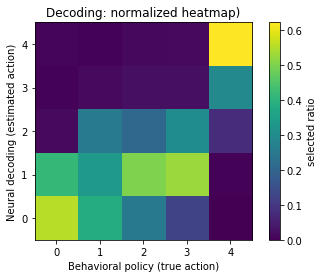

In [28]:
plt.imshow(H/np.sum(H,axis=0), interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
cbar = plt.colorbar()
cbar.set_label('selected ratio')
plt.xlabel('Behavioral policy (true action)') 
plt.ylabel('Neural decoding (estimated action)')
plt.title('Decoding: normalized heatmap)')
plt.savefig('./figures/decoding_KRR.eps', format = 'eps')

### build csv file